# Data Parameters
(Basically, this will be deleted, as we keep iterating on this until we can get the next checkpoint)

Input

- Frames: 5 in 5 out
- Target: 1 station (LA N. Main St.)
- Channels: AirNow, Wind U/V

Model
- Variation
```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 1600)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5, 1)           │         1,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
```
- Adam 1e-4 LR, 1e-2 WD

Result
- ?

General Notes
- Trying out 5 frame out prediction

In [1]:
# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime
import sys
sys.path.append("../..")
#from libs.sequence import PWWBPyDataset

In [3]:
X_test_files =  ["METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "AirNow_PM25_X_test.npy"]
X_train_files = ["METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "AirNow_PM25_X_train.npy"]
X_valid_files = ["METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "AirNow_PM25_X_valid.npy"]

Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [4]:
''' y is not trimmed, can't use this method
BATCH_SIZE = 32
X_training_files_paths = [f"{path + file}" for file in X_train_files]
Y_training_files_paths = f"{path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)
'''
path = "final_input_data/two_years_with_hrrr/"
X_train = np.stack([np.load(f"{path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{path + Y_train_files}")
Y_test = np.load(f"{path + Y_test_files}")
Y_valid = np.load(f"{path + Y_valid_files}")

In [5]:
# 5 frames in, one frame and one station out
# next frame = 0
# LA station = 4
Y_train = Y_train[:, :, [4]].copy()
Y_test = Y_test[:, :, [4]].copy()
Y_valid = Y_valid[:, :, [4]].copy()

# Model Definition

## Architecture

In [6]:
output_size = 1
input_shape = X_train.shape[1:] # (frames, height, width, channels)

print(
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape}\n"
    f"Output shape:  ({output_size})\n"
)

X_train shape: (12274, 5, 40, 40, 3)
Y_train shape: (12274, 5, 1)

X_test shape:  (2631, 5, 40, 40, 3)
Y_test shape:  (2631, 5, 1)

X_valid shape: (2630, 5, 40, 40, 3)
Y_valid shape: (2630, 5, 1)

Input shape:   (5, 40, 40, 3)
Output shape:  (1)



In [7]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, LayerNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape, GlobalAveragePooling2D
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=input_shape)
)

seq.add(
    ConvLSTM2D(
        filters=15, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.1,
        #recurrent_dropout=0.1,
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.1,
        #recurrent_dropout=0.1,
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same',
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same',
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

# applies layer to every temporal slice (first dimension)
# so for (5, 40, 40, 1), the layer is applied to each frame, a total of 5 times
seq.add(TimeDistributed(Flatten()))
#seq.add(Flatten())

#seq.add(Dropout(rate=0.1))

seq.add(Dense(output_size, activation='relu'))

seq.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.01)
)
seq.summary()

2025-07-06 18:26:56.994802: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 18:26:57.028568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751851617.040844   68402 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751851617.045306   68402 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-06 18:26:57.080125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 1600)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5, 1)           │         1,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,672 (283.88 KB)

 Trainable params: 72,672 (283.88 KB)

 Non-trainable params: 0 (0.00 B)

## Callbacks

In [8]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_file = 'experiment_output/basic_experiments/model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    early_stopping_callback,
    model_checkpoint_callback,
    #lr_scheduling_callback,
    #tensorboard_callback,
    #gradient_logging_callback
]

## Training

In [9]:
history = seq.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_valid, Y_valid),
    callbacks=callbacks
)

Epoch 1/200


I0000 00:00:1751851622.533872   68485 service.cc:148] XLA service 0x6251f8c13c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751851622.533890   68485 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-07-06 18:27:02.615402: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751851622.944506   68485 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-07-06 18:27:03.503539: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backen

  3/384 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 9.7212

I0000 00:00:1751851625.604483   68485 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 7.6578

2025-07-06 18:27:26.801981: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[18,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 18:27:26.925950: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[18,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 7.6528

2025-07-06 18:27:31.173576: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[6,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 18:27:31.215043: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[6,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

384/384 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - loss: 7.6477 - val_loss: 3.9232
Epoch 2/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 3.7725 - val_loss: 3.6054
Epoch 3/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 3.6097 - val_loss: 3.4235
Epoch 4/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 3.5186 - val_loss: 3.3286
Epoch 5/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 3.5036 - val_loss: 3.2580
Epoch 6/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 3.3727 - val_loss: 3.1814
Epoch 7/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 3.3187 - val_loss: 3.5315
Epoch 8/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 3.3692 - val_loss: 3.2437
Epoch 9/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 3.3091 - val_loss: 3.1717
Epoch 10/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 3.2820 - val_loss: 3.0985
Epoch 11/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 3.1861 - val_loss: 3.1829
Epoch 12/200
384/384 ━━━━━━━━━━

# Model Evaluation


Evaluating model


2025-07-06 18:39:45.013867: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[7,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 18:39:45.054780: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

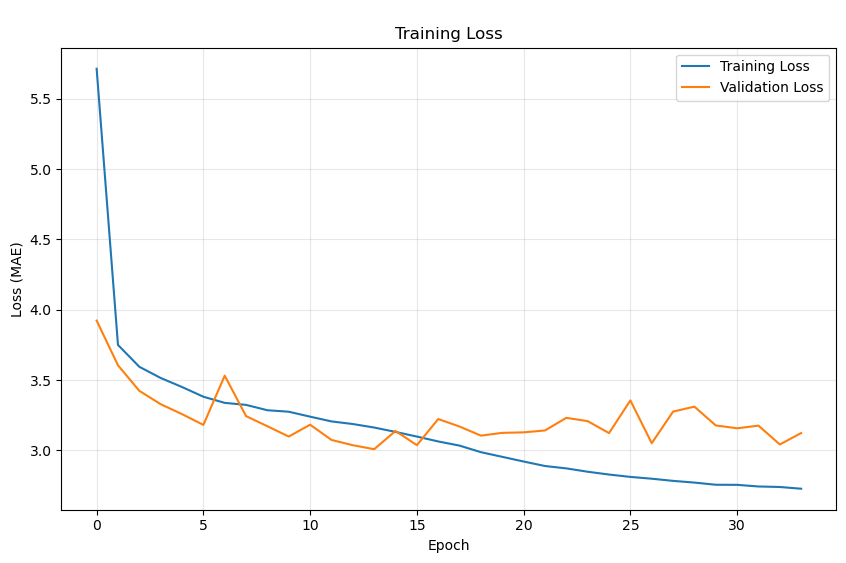

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = seq.predict(X_test, verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
import sys
sys.path.append('../..')
from libs.plotting import *
import pandas as pd

results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.338691,4.411293,4.068113
NRMSE,16.806614,31.709109,29.234819
MAE,1.462471,3.098035,2.806818
R2,0.867793,0.529830,0.599967


In [12]:
# clean up dead sensors
dead_sens = np.where(Y_test == 0)
print(len(dead_sens[0]))

cleaned_test = np.delete(Y_test, dead_sens)
cleaned_pred = np.delete(y_pred, dead_sens)
print(cleaned_test.shape)
print(cleaned_pred.shape)

results = [
    [
        rmse(cleaned_test[1:], cleaned_test[:-1]), 
        rmse(cleaned_pred, cleaned_test),
        rmse(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        nrmse(cleaned_test[1:], cleaned_test[:-1]),
        nrmse(cleaned_pred, cleaned_test),        
        nrmse(cleaned_pred[1:], cleaned_test[:-1]),

    ],
    [        
        mae(cleaned_test[1:], cleaned_test[:-1]),
        mae(cleaned_pred, cleaned_test),
        mae(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        r2_score(cleaned_test[:-1], cleaned_test[1:]),
        r2_score(cleaned_test, cleaned_pred),
        r2_score(cleaned_test[:-1], cleaned_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

75
(13115,)
(13115,)


,Baseline Error,Model Error,Model Error Shifted
RMSE,2.925006,4.415970,4.448803
NRMSE,21.015087,31.728425,31.963012
MAE,1.810012,3.101674,3.086335
R2,0.793771,0.529959,0.522930


🎯 COMPREHENSIVE CONVLSTM PERFORMANCE ANALYSIS
📊 Analyzing 5 frames (hours) across 1 sensors
📈 Dataset: 2631 samples

This analysis evaluates ConvLSTM's ability to predict air quality across multiple future time frames
and spatial locations, revealing critical spatio-temporal prediction patterns.

📊 1. FRAME-BY-FRAME RMSE
────────────────────────────────────────────────────────────
📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



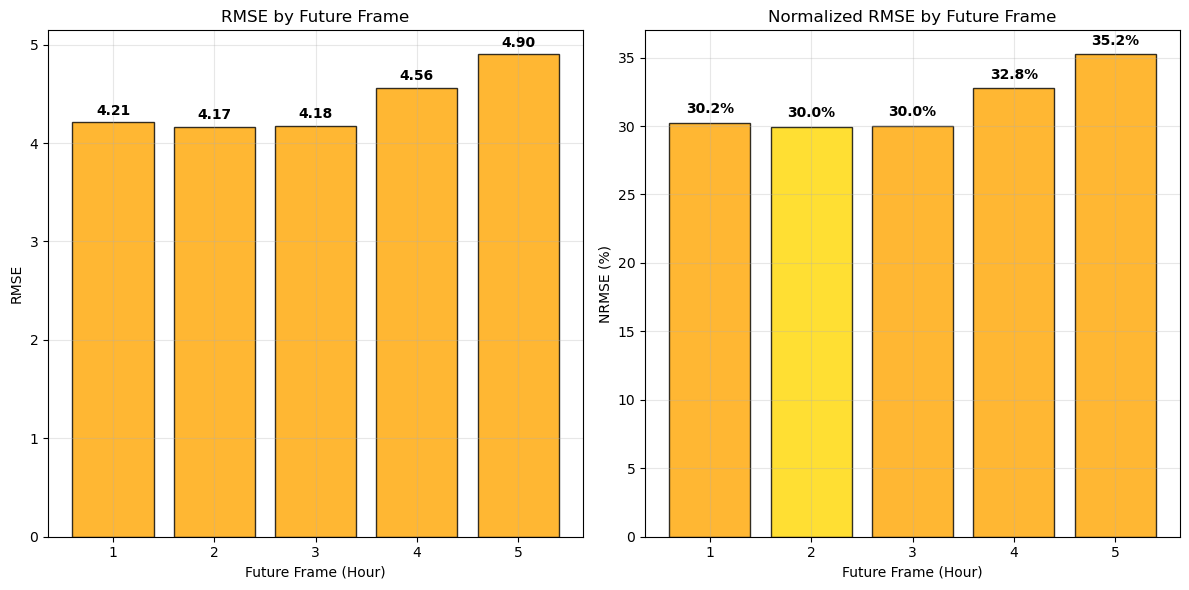


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 4.209 (30.2%)
Hour 2: RMSE = 4.168 (30.0%)
Hour 3: RMSE = 4.177 (30.0%)
Hour 4: RMSE = 4.556 (32.8%)
Hour 5: RMSE = 4.900 (35.2%)

📍 2. AVERAGE RMSE PER STATION (ALL HOURS)
───────────────────────────────────────────────────────
📍 SPATIAL PERFORMANCE ANALYSIS
This identifies which monitoring stations are consistently difficult for ConvLSTM to predict.
Challenging stations often have complex local meteorology or unique pollution sources.



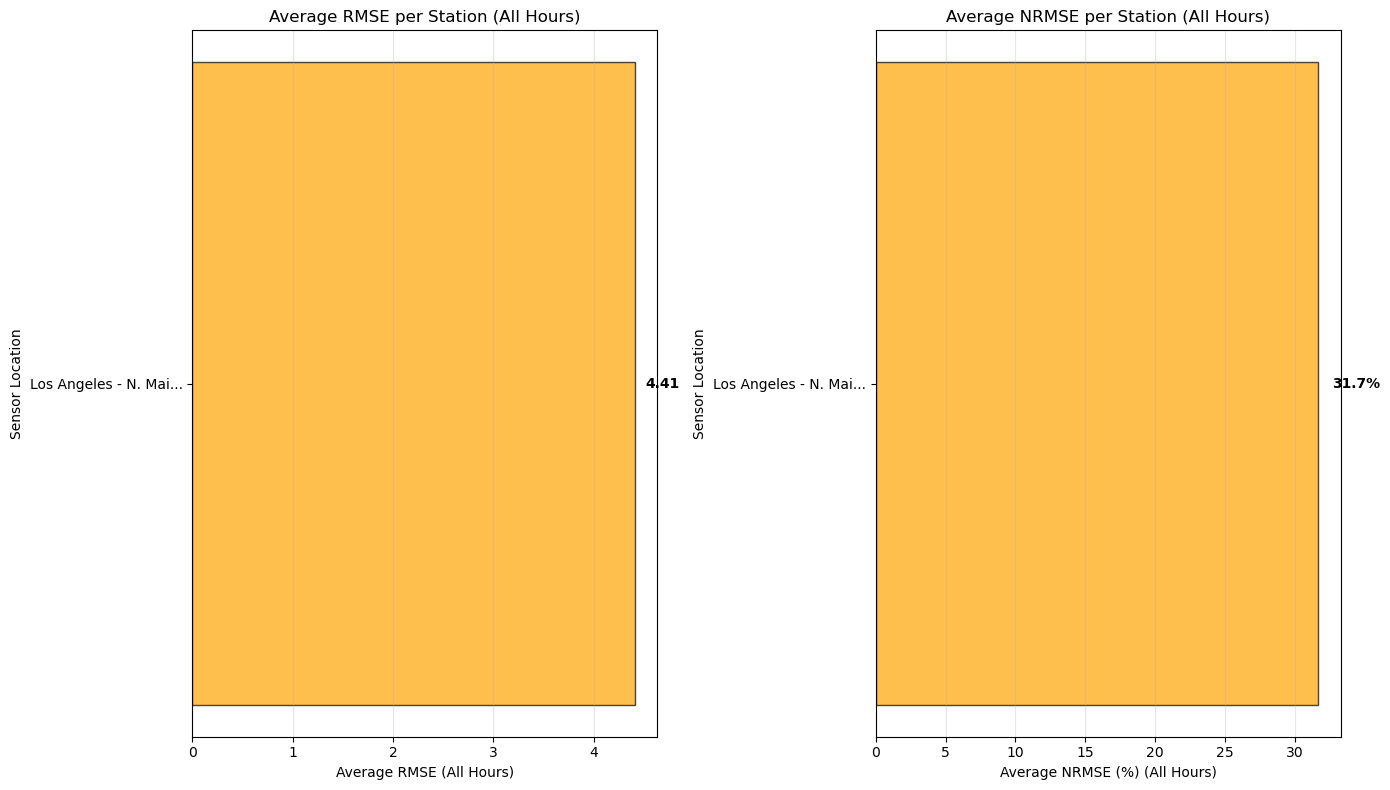


📍 STATION PERFORMANCE SUMMARY (All Hours Combined)

🟢 EXCELLENT Stations (RMSE < 1.5): 0

🟡 GOOD Stations (1.5-3.0): 0

🟠 FAIR Stations (3.0-5.0): 1
   • Los Angeles - N. Main Street: 4.411

🔴 POOR Stations (≥ 5.0): 0

📊 SUMMARY STATISTICS:
   🏆 Best Station:  Los Angeles - N. Main Street (RMSE: 4.411)
   💥 Worst Station: Los Angeles - N. Main Street (RMSE: 4.411)
   📈 Average RMSE:  4.411
   📏 RMSE Range:    0.000
   🎯 Reliability:   0/1 stations ≤ 3.0 RMSE

📊 SUMMARY TABLE - RMSE BY HOUR AND SENSOR
Sensor                   │ Hour 1 │ Hour 2 │ Hour 3 │ Hour 4 │ Hour 5 │  Avg   
─────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────
Los Angeles - N. Main St │  4.21  │  4.17  │  4.18  │  4.56  │  4.90  │  4.40  
─────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────
HOURLY AVERAGE           │  4.21  │  4.17  │  4.18  │  4.56  │  4.90  │  4.40  

🎯 KEY: Excellent(<1.5) Good(1.5-3.0) Fair(3.0-5.0) Poor(≥5.0)

🔥 3. RMSE HEATMAP (OVERVIEW)


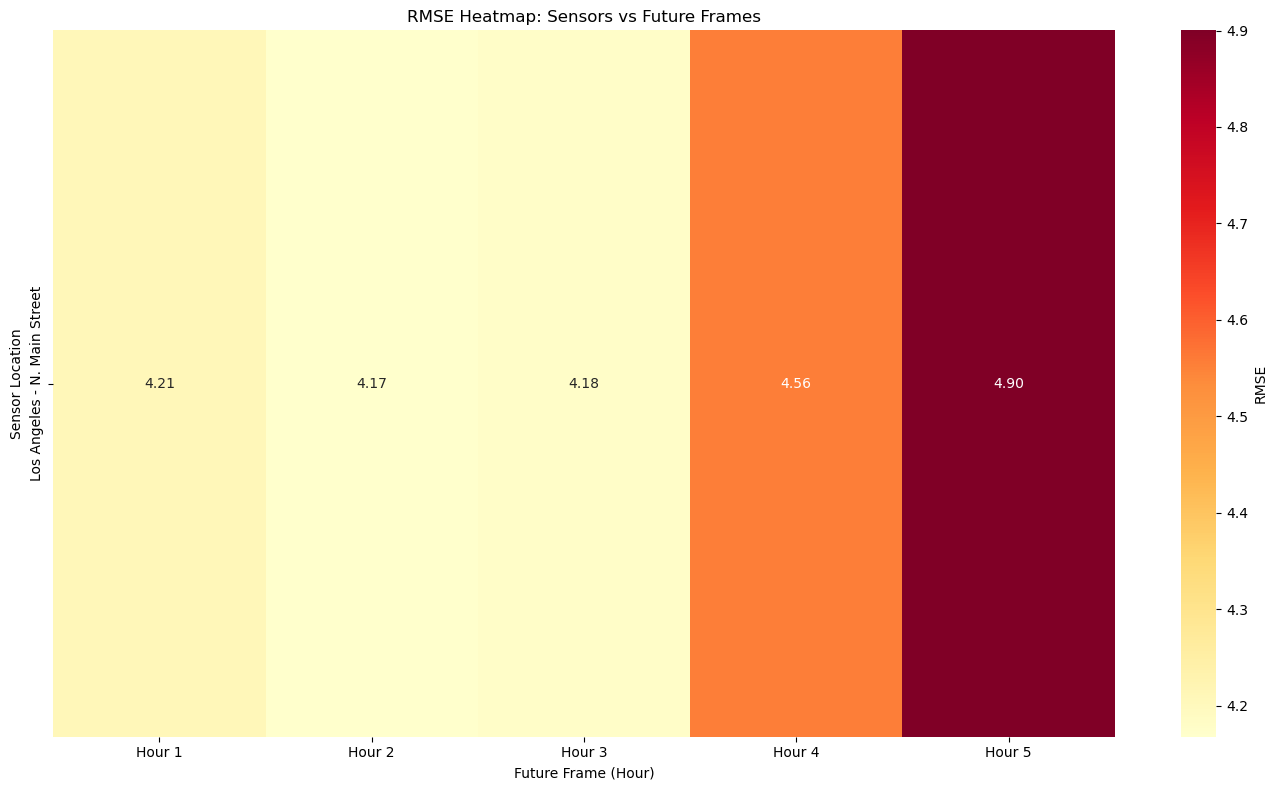


🔥 WORST PERFORMING COMBINATIONS:
Los Angeles - N. Main Street at Hour 5: RMSE = 4.900
Los Angeles - N. Main Street at Hour 4: RMSE = 4.556
Los Angeles - N. Main Street at Hour 1: RMSE = 4.209
Los Angeles - N. Main Street at Hour 3: RMSE = 4.177
Los Angeles - N. Main Street at Hour 2: RMSE = 4.168

📈 4. TIME SERIES BY FRAME
───────────────────────────────────
Temporal pattern analysis

🕐 Hour 1 Time Series


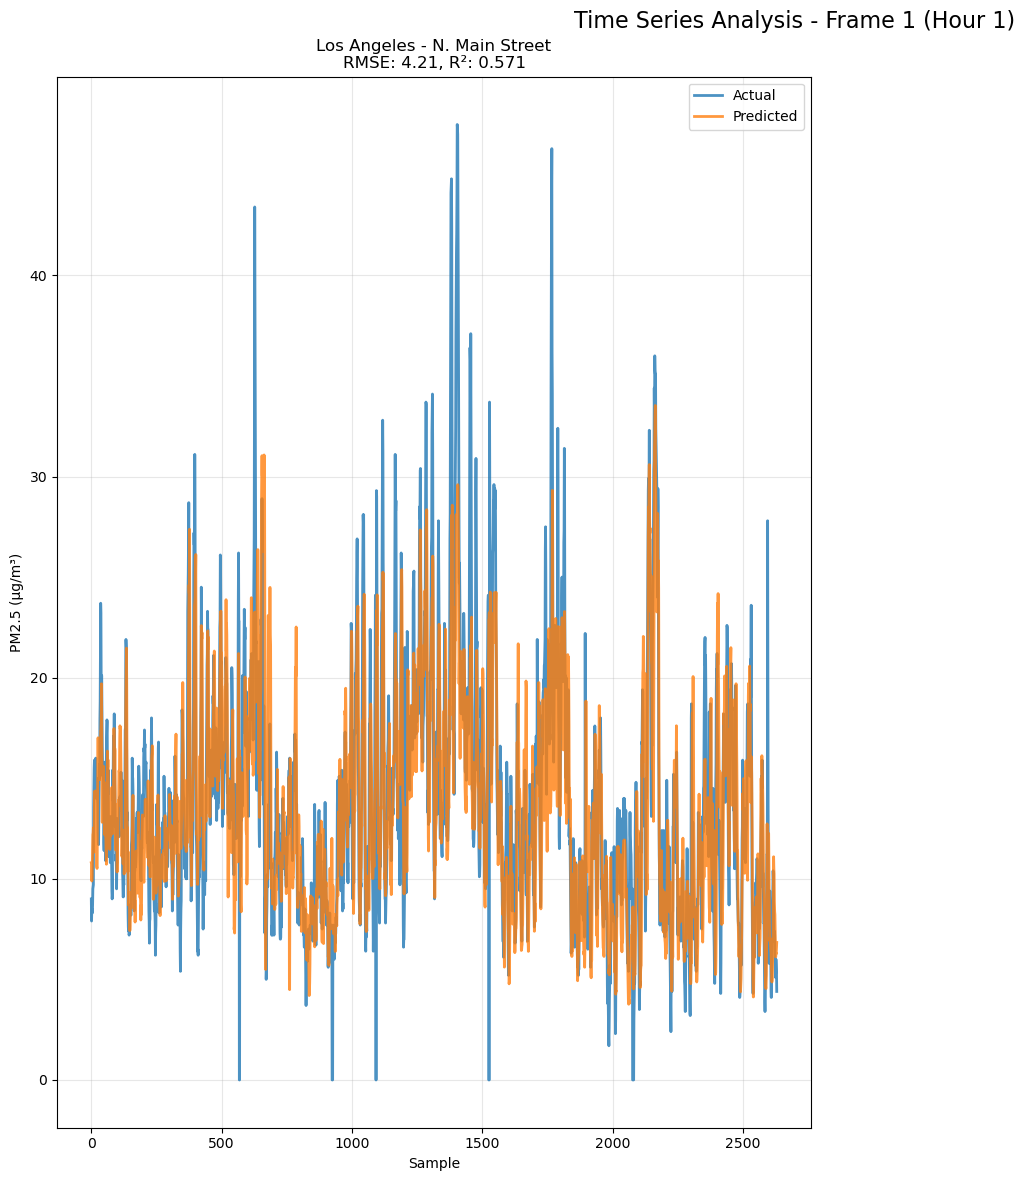


🕐 Hour 2 Time Series


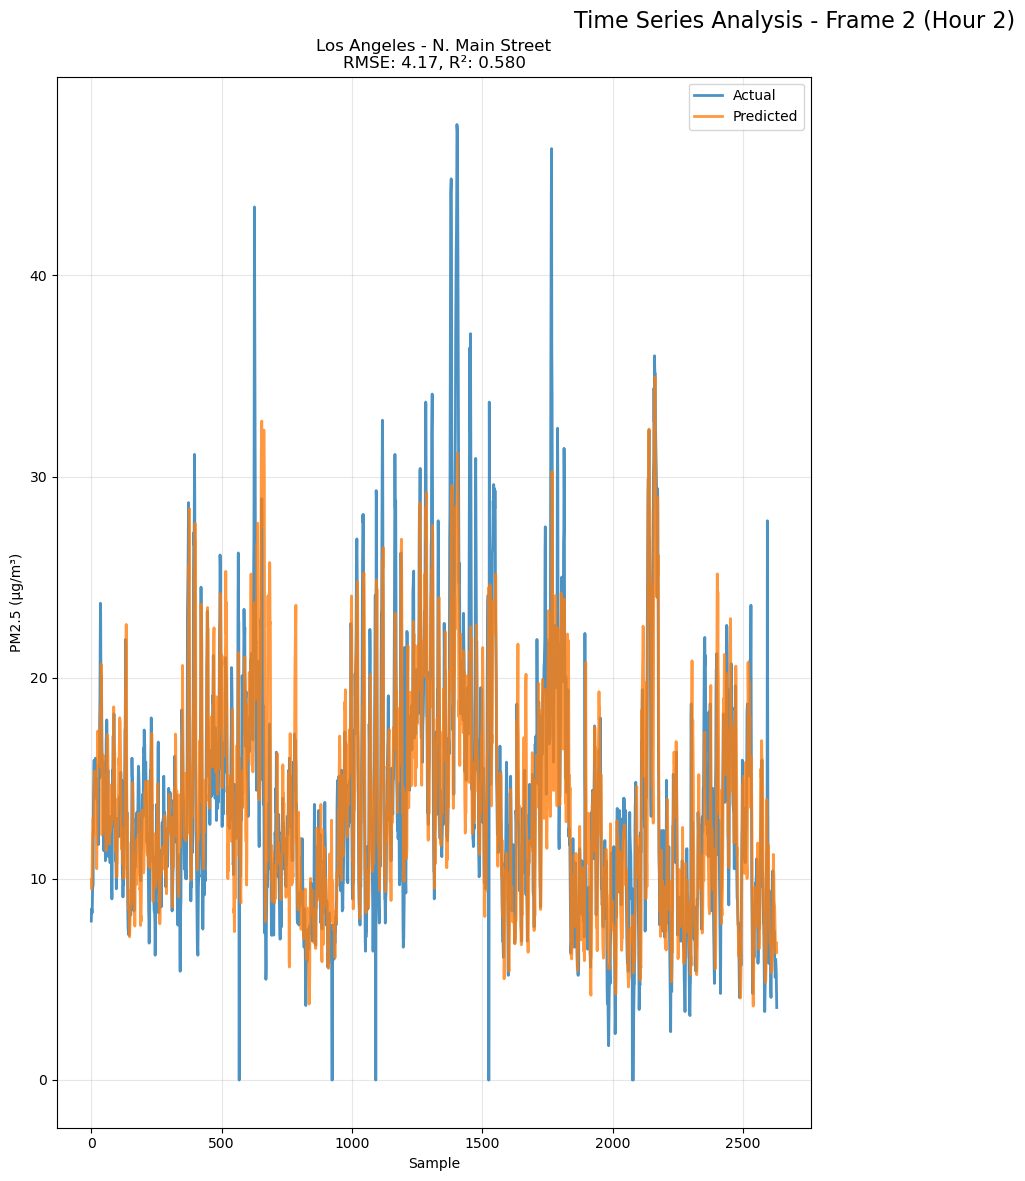


🕐 Hour 3 Time Series


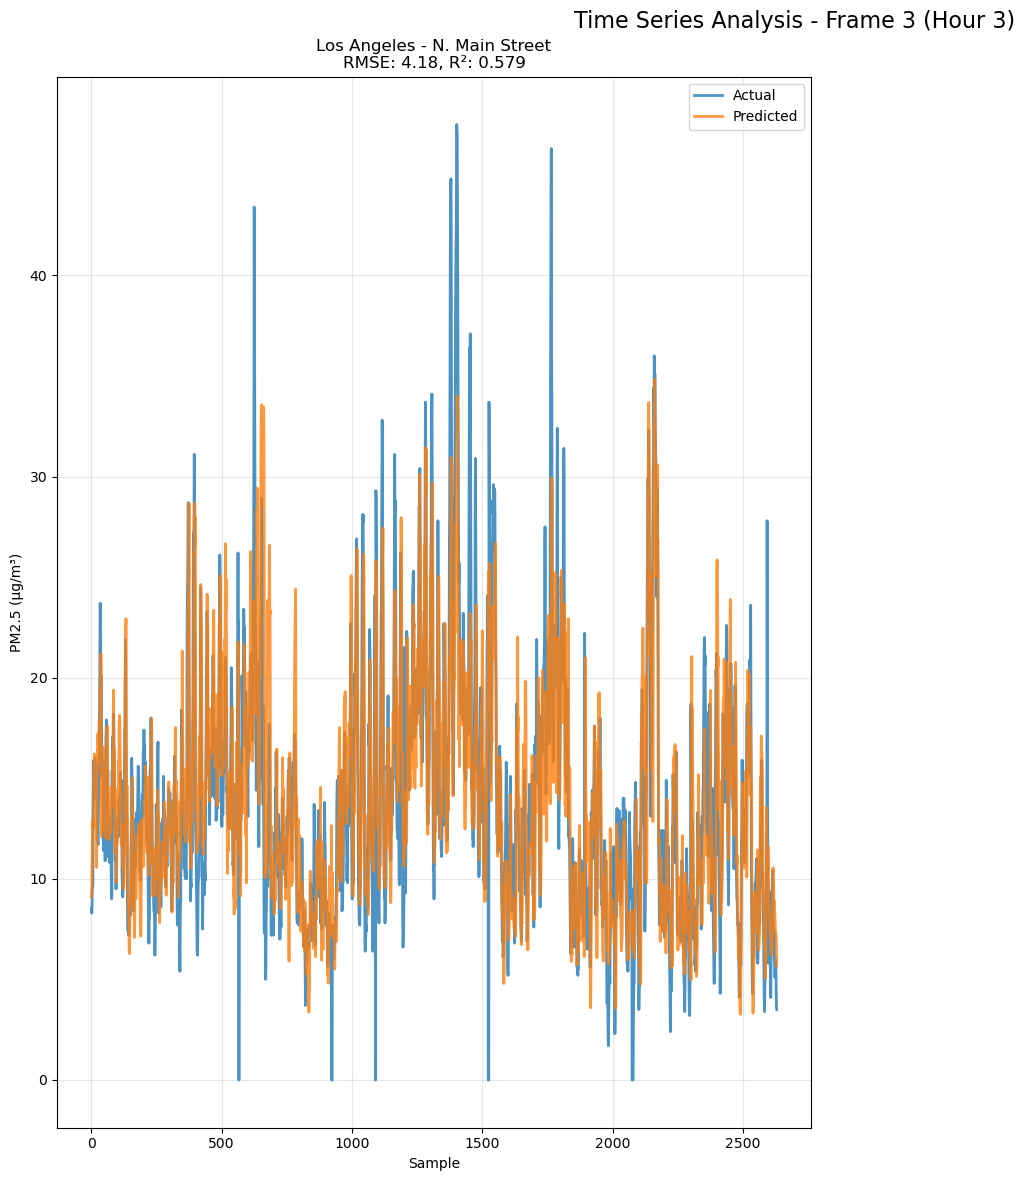


🕐 Hour 4 Time Series


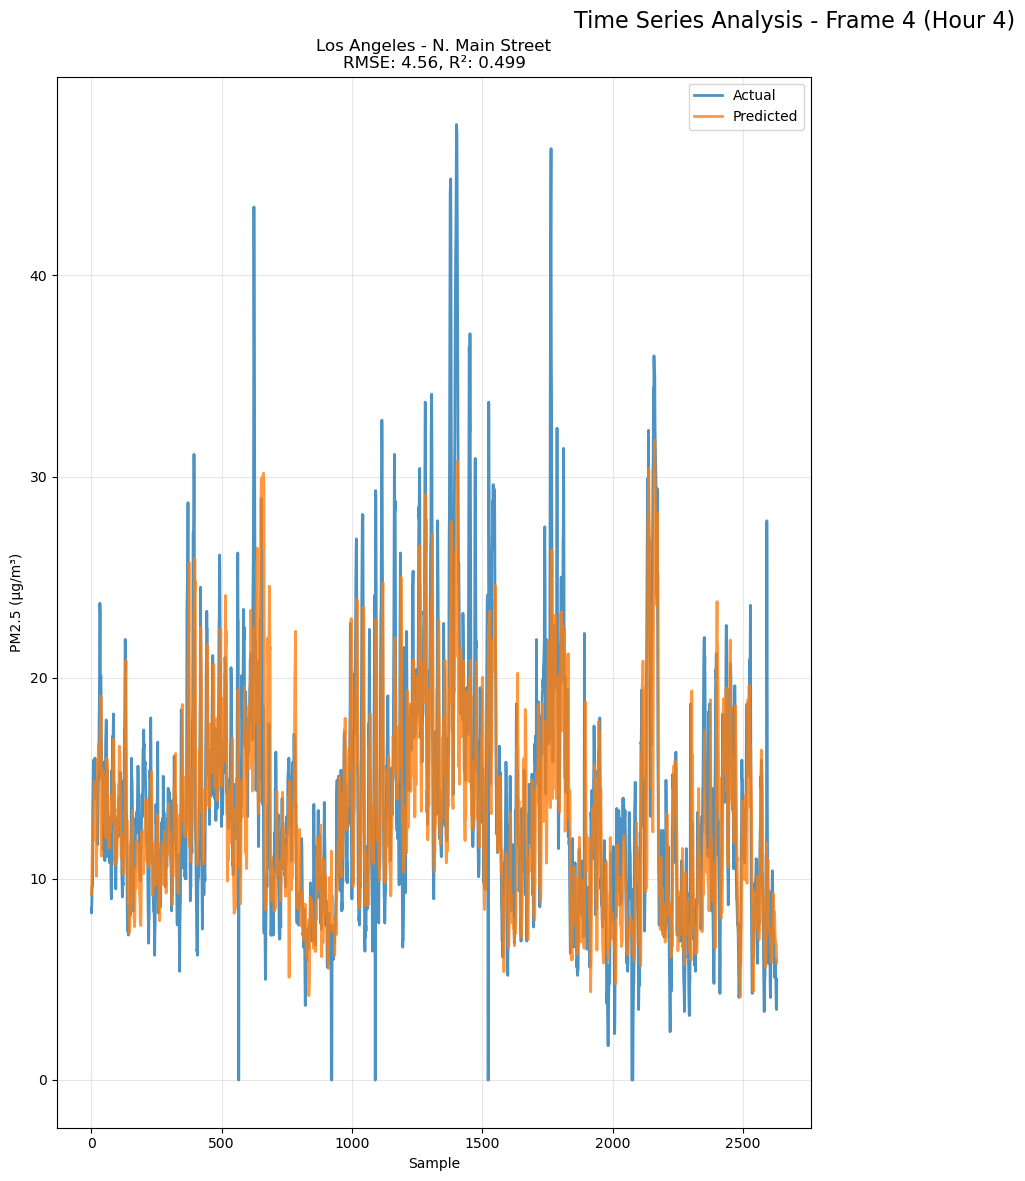


🕐 Hour 5 Time Series


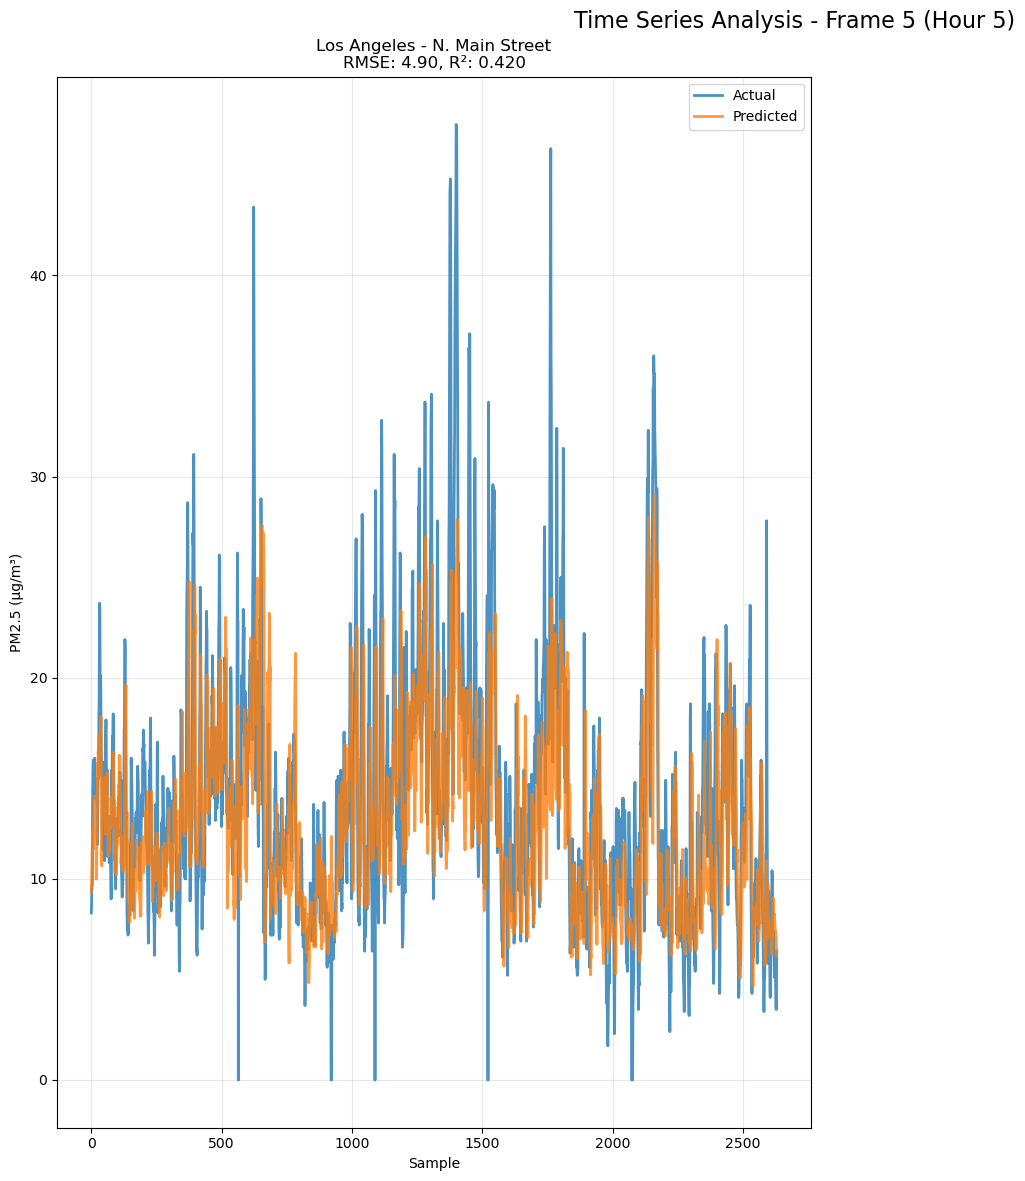


🎯 5. SCATTER PLOTS BY FRAME
───────────────────────────────────
Prediction accuracy assessment for each time frame:

🎯 Hour 1 Scatter Plot


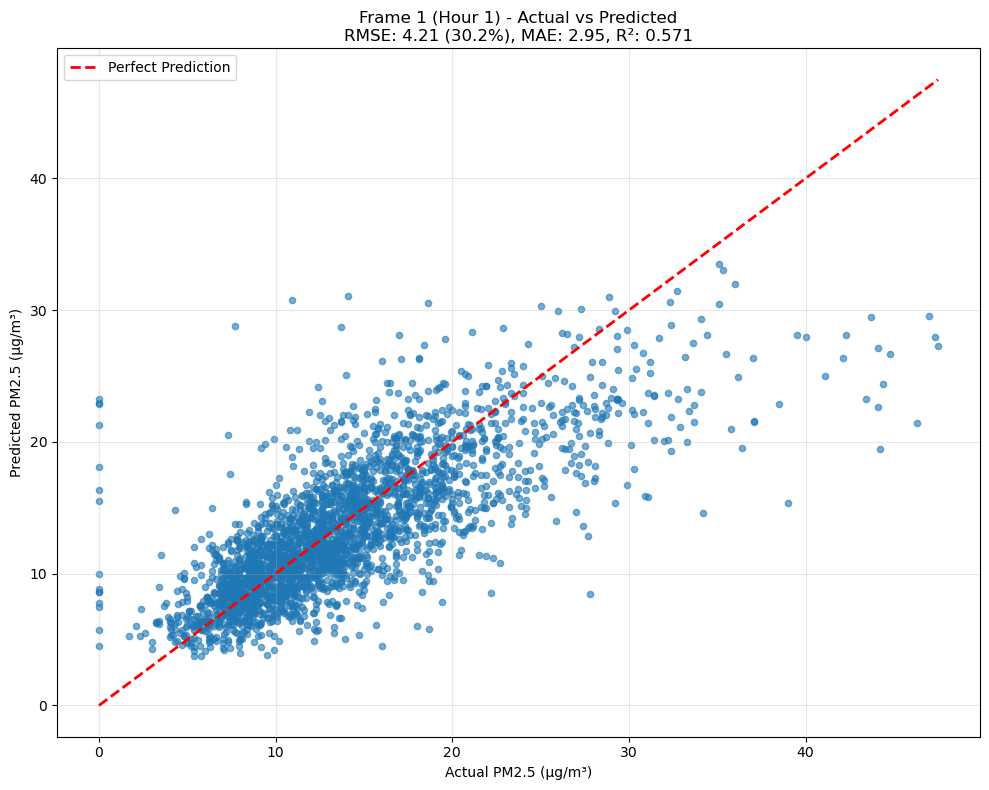


🎯 Hour 2 Scatter Plot


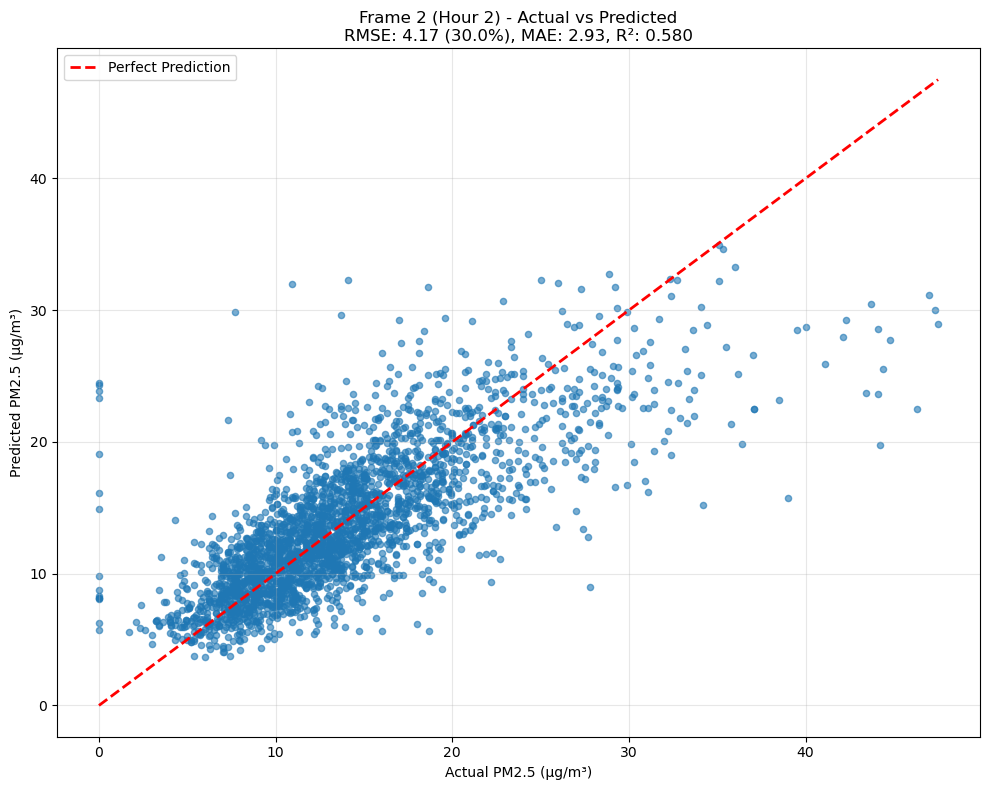


🎯 Hour 3 Scatter Plot


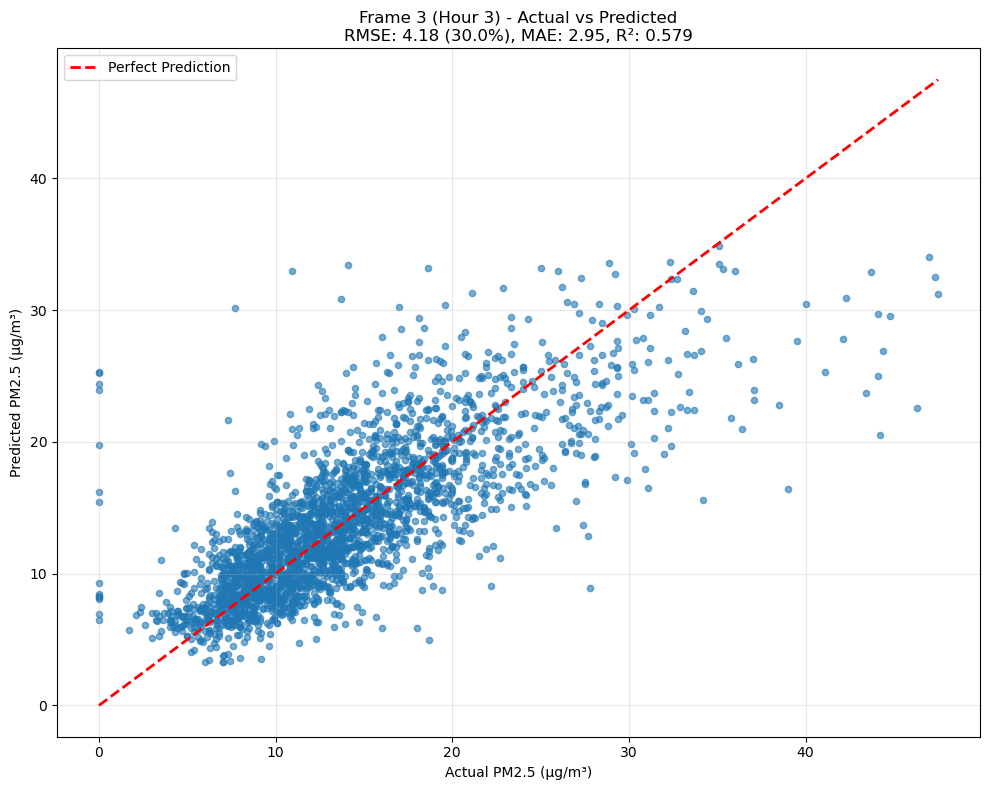


🎯 Hour 4 Scatter Plot


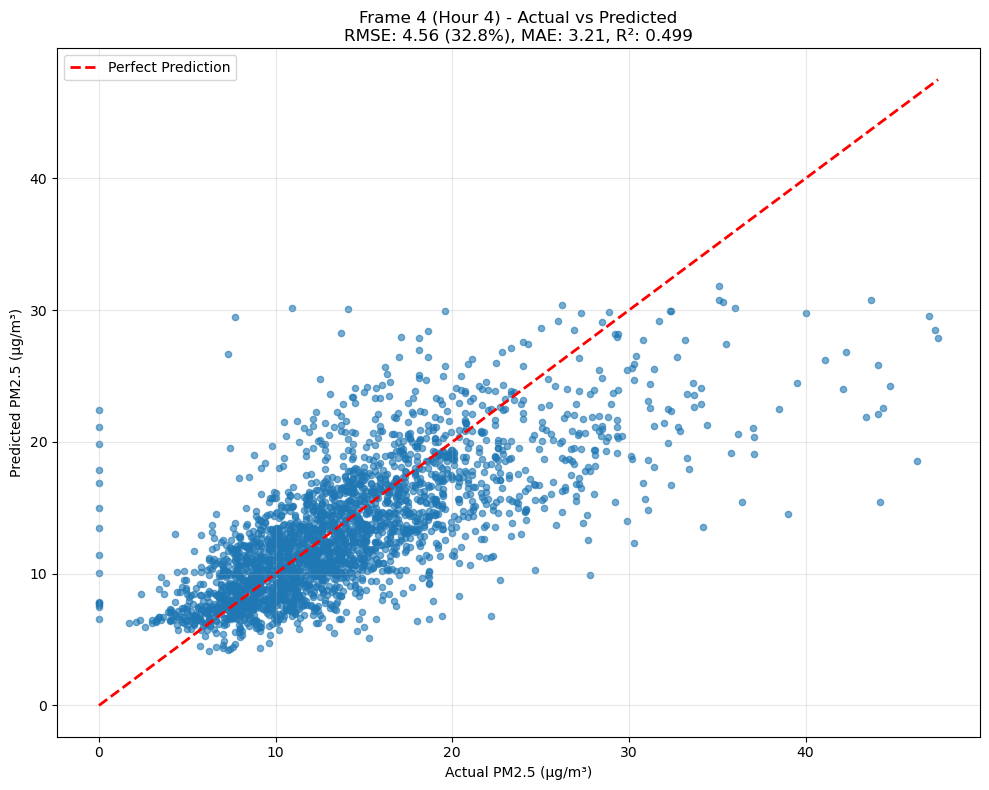


🎯 Hour 5 Scatter Plot


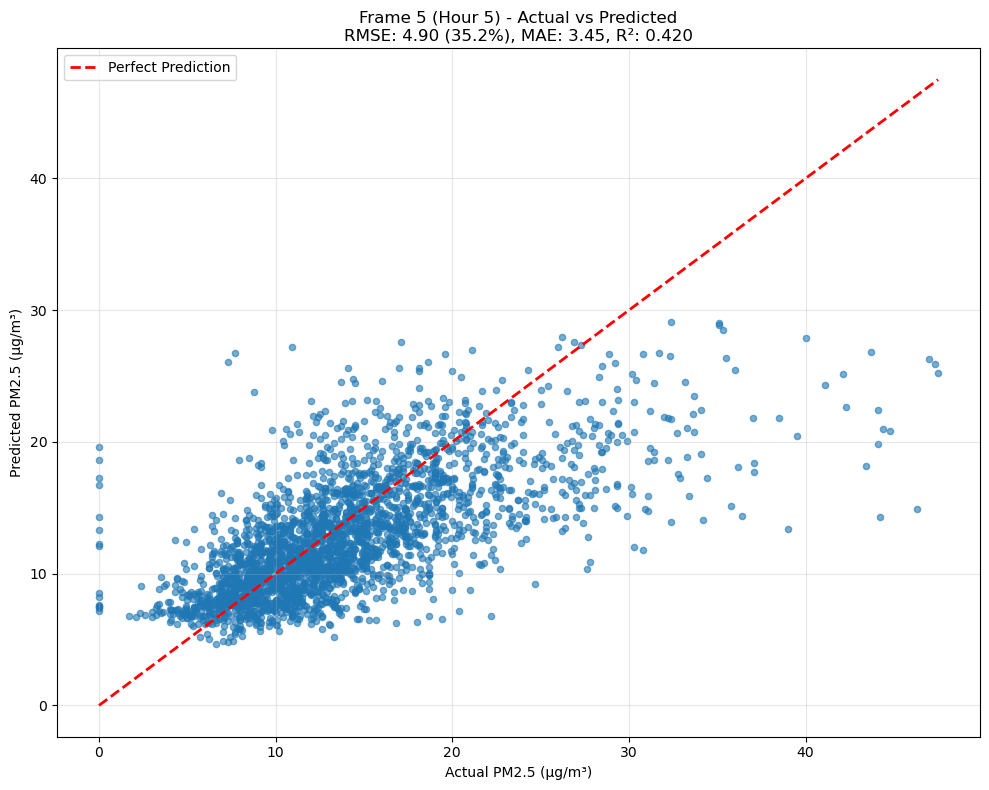

📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  4.209 (30.2%)   │   MAE:  2.951   │   R²:  0.571              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Los Angeles - N. Main St │4.21   │30.2  %│2.95   │0.571  │13.9   │13.4  
──────────────────────────────────────────────

In [13]:
sensor_names = ['Los Angeles - N. Main Street']
comprehensive_frame_analysis(y_pred, Y_test, sensor_names)

# Plots

## Snapshot plots

In [21]:
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

worst_week_cleaned = float('-inf')
worst_idx_cleaned = 0
for i in range(len(y_pred) - 168):
    err = nrmse(y_pred[i:i+168, 0], Y_test[i:i+168, 0])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i

    cleaned_err = nrmse(cleaned_pred[i:i+168, 0], cleaned_test[i:i+168, 0])
    if cleaned_err > worst_week_cleaned:
        worst_week_cleaned = cleaned_err
        worst_idx_cleaned = i

print(f"Best week {best_idx} to {best_idx+168} at {best_week:.2f}%")
print(f"Worst week {worst_idx} to {worst_idx+168} at {worst_week:.2f}%")
print(f"Worst week cleaned {worst_idx_cleaned} to {worst_idx_cleaned+168} at {worst_week_cleaned:.2f}%")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

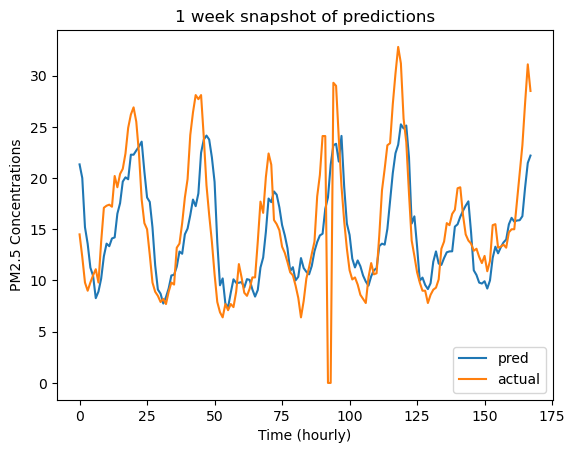

In [16]:
plt.plot(y_pred[1000:1168, 0], label='pred')
plt.plot(Y_test[1000:1168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions")
plt.legend(loc="lower right")

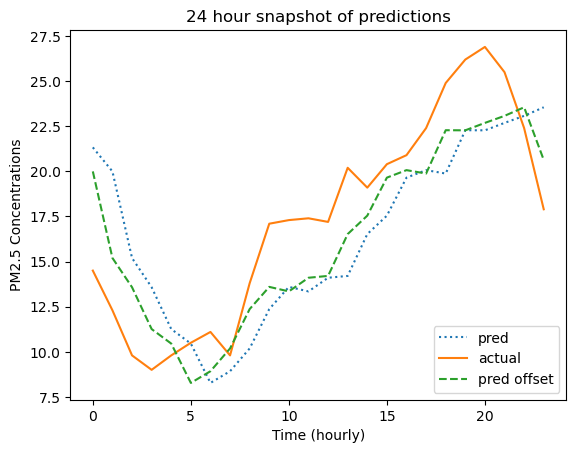

In [17]:
plt.plot(y_pred[1000:1024, 0], linestyle=':', label='pred')
plt.plot(Y_test[1000:1024, 0], label='actual')
plt.plot(y_pred[1001:1025, 0], linestyle='--', label='pred offset')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("24 hour snapshot of predictions")
plt.legend(loc="lower right")

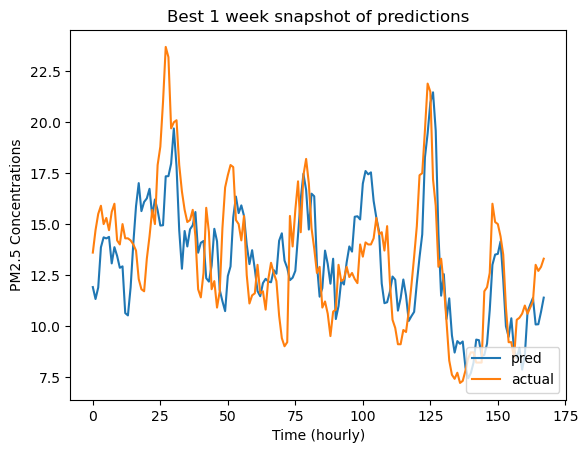

In [18]:
plt.plot(y_pred[best_idx:best_idx+168, 0], label='pred')
plt.plot(Y_test[best_idx:best_idx+168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("Best 1 week snapshot of predictions")
plt.legend(loc="lower right")

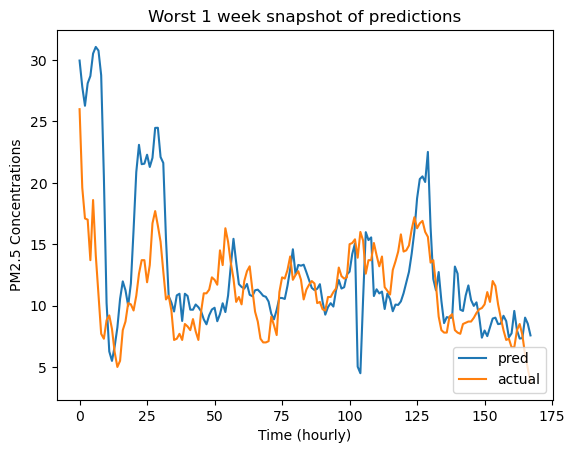

In [19]:
plt.plot(y_pred[worst_idx:worst_idx+168, 0], label='pred')
plt.plot(Y_test[worst_idx:worst_idx+168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("Worst 1 week snapshot of predictions")
plt.legend(loc="lower right")

In [20]:
plt.plot(cleaned_pred[worst_idx_cleaned:worst_idx_cleaned+168, 0], label='pred')
plt.plot(cleaned_test[worst_idx_cleaned:worst_idx_cleaned+168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("Worst 1 week snapshot of predictions (cleaned)")
plt.legend(loc="upper right")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Rolling avg plots

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred, label=f'pred', color='red')
plt.plot(Y_test, label=f'actual', color='blue')
plt.title('Time Series (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

series_pred = pd.Series(np.squeeze(y_pred))
series_test = pd.Series(np.squeeze(Y_test))

window_size = 24 # daily average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 24-hour Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Daily Average')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
series_pred = pd.Series(np.squeeze(y_pred))
series_test = pd.Series(np.squeeze(Y_test))

window_size = 168 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with Weekly Moving Average Smoothing')
plt.xlabel('Week')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
series_pred = pd.Series(np.squeeze(y_pred))
series_test = pd.Series(np.squeeze(Y_test))

window_size = 720 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

## Error plots

In [ ]:
series = pd.Series(np.squeeze(np.abs(y_pred - Y_test)))
plt.figure(figsize=(10, 6))
plt.plot(series, label=f'error', color='red')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cleaned_series = pd.Series(np.squeeze(np.abs(cleaned_pred - cleaned_test)))
plt.figure(figsize=(10, 6))
plt.plot(cleaned_series, label=f'error', color='blue')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
window_size = 24 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
window_size = 24 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
window_size = 168 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
window_size = 168 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
window_size = 720 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
window_size = 720 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()